# **Test on the capabilities of our model** 🏋

In [1]:
from model import *
from optax import adam
from src.datagen import Equations
import os
from jax import jit, vmap, random
import jax
import matplotlib.pyplot as plt
import time
import scienceplots

jax.config.update("jax_enable_x64", True)
plt.style.use('science')

## Test the purely raw model

In [2]:
state_variables = 20
expected_number_of_nls = 5
input_dim = state_variables * expected_number_of_nls
output_dim = state_variables

model = ZeroLayersNN(N=input_dim, L=expected_number_of_nls, output_dim=state_variables)
seed = 42
batch_size = 32


dummy_input = jnp.zeros((batch_size, input_dim))
key = random.key(seed)
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
optimizer = adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

Then we create the random non linearities:

- **generate_alphabeta**: This function generates orthonormal basis vectors using QR decomposition. It takes three parameters: `dim` (the dimension of the matrix), `num` (the number of basis vectors), and `seed` (a seed for random number generation). The function creates a random matrix `A` of shape `(dim, num)` and then performs QR decomposition on `A` to obtain an orthonormal matrix `Q`. The function returns `Q`.
- **generate_callable_functions**: This function generates a set of callable functions based on the orthonormal basis vectors generated by `generate_alphabeta`. It takes three parameters: `dim` (the dimension of the matrix), `num` (the number of functions to generate), and `seed` (a seed for random number generation). The function splits the basis vectors into three parts: `alphas`, `betas`, and `gammas`. It then defines a nested function `make_function` that creates a callable function using these vectors. The `make_function` uses JAX's `jit` decorator to compile the function for faster execution. The main function returns a tuple containing the generated functions and the transposed basis vectors.

In [3]:
def generate_alphabeta(dim, num, seed):

    key = random.key(seed)
    shape = (dim, num)
    A = random.normal(key, shape)
    Q, _ = jnp.linalg.qr(A)
    return Q * 10

def generate_callable_functions(dim, num, seed):

    bases = generate_alphabeta(dim, num, seed)  # Get num basis vectors
   
    alphas = bases[:dim//2, :].T  # First half of Q are alphas
    gammas = bases[dim//2:, :].T

    def make_function(alpha, gamma):
        @jit
        def func(x):
            return (alpha[0] * nn.relu(x + gamma[0]) +
                    alpha[1] * nn.relu(x + gamma[1]) +
                    alpha[2] * nn.relu(x + gamma[2]))
        return func
    
    return tuple([make_function(alphas[i], gammas[i]) for i in range(num)]), bases.T

Now we want to work with the simplest case possible.


In [4]:
dims = 6
n_nls = 5
alphagamma = generate_alphabeta(dims, n_nls, seed)
alphas = alphagamma[:dims//2, :].T  # First half of Q are alphas
gammas = alphagamma[dims//2:, :].T
print("Alphas:", alphas)
print("Gammas:", gammas)

non_lins, vec_nls = generate_callable_functions(dims, n_nls, seed)

config = {
    "n_vars": state_variables,
    "n_eqs": state_variables,
    "bounds_addends": (1, 3),
    "bounds_multiplicands": (1, 1),
    "non_lins": non_lins,
    "sym_non_lins": None,
    "distribution": "uniform",
    "a": None,
    "b": None,
    "sigma": None,
    "p": None,
    "seed": seed
}

Alphas: [[-4.72350633  4.98900944 -2.22880297]
 [ 1.74802009 -5.10872158 -1.27046248]
 [-0.90109363  3.80842853  0.06274223]
 [-4.90581745 -0.79685476 -5.47846948]
 [-3.66701709 -5.47130689 -2.71841749]]
Gammas: [[ 2.46257795  0.55233226  6.43904877]
 [-3.09998931  5.39552182  5.52356092]
 [-0.14223513  8.16782402 -4.23631748]
 [-6.10191766 -1.48716614 -2.41646177]
 [ 6.60409031  1.23307706 -2.02324125]]


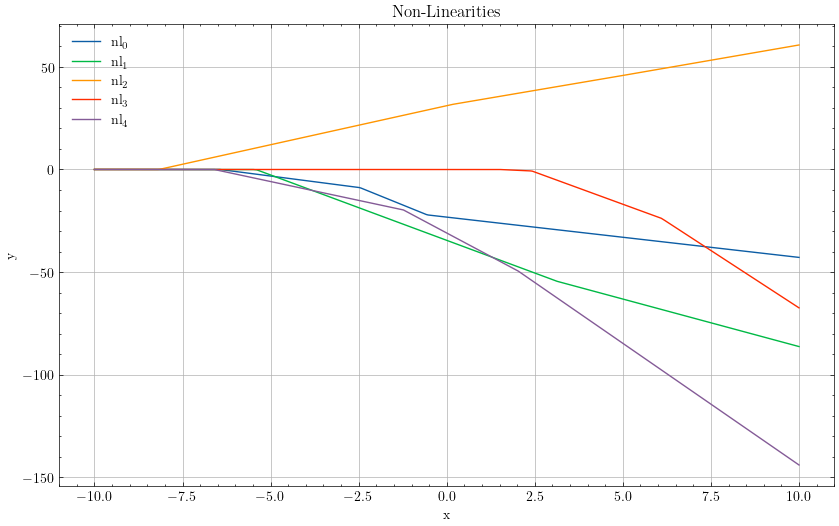

In [5]:
x = jnp.linspace(-10, 10, 400)

# Plot each callable's result
plt.figure(figsize=(10, 6))
i = 0
for func in non_lins:
    y = func(x)
    plt.plot(x, y, label=r"$\text{nl}_{%d}$" % i)
    i += 1

# Adding labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Non-Linearities')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
plt.clf()
plt.close()

In [6]:
system = Equations(config)
system.save_symb_expr()

System and state saved as equations_1b1e7ccc068166d7578a589596465bb9.pkl in directory Data
PDF saved as equations_1b1e7ccc068166d7578a589596465bb9_symbolic.pdf


<Figure size 350x262.5 with 0 Axes>

### Linspace

Let's try to train the model with data sampled by linspace. The test set is taken out of bounds with respect to the training data, in such way it is possible to verify the generalization abilities of the model.

In [7]:
def my_eval(v):
    return system(y=v)

In [8]:
bound = 15
train_size = int(1e4)
test_ratio = 0.2
test_size = int(test_ratio * train_size)
total_size = train_size + test_size
train_values = jnp.tile(jnp.linspace(-1 * bound, bound, total_size).reshape(-1, 1), (1, config['n_eqs']))

# Randomly select `test_size` elements for inbound_test
key = random.key(seed)
key, subkey = random.split(key)  # Ensure reproducibility
indices = random.choice(subkey, total_size, shape=(test_size,), replace=False)  # Unique indices
inbound_test = train_values[indices]  # Extract test points
mask = jnp.ones(total_size, dtype=bool)
mask = mask.at[indices].set(False)  # Mask out test points
train_values = train_values[mask]  # Remove test points from training set

# Create out-of-bound test values
range1 = jnp.linspace(-1 * bound - 5, -1 * bound, test_size//2)
range2 = jnp.linspace(bound, bound + 5, test_size//2)
outofbound_test = jnp.concatenate((range1, range2), axis=0).reshape(-1, 1)
outofbound_test = jnp.tile(outofbound_test, (1, config['n_eqs']))

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate train and test values
values = jnp.vstack((train_values, stacked_test))

# Evaluate
evaluated_values = vmap(my_eval)(values)

In [9]:
print(train_values.shape, inbound_test.shape, outofbound_test.shape)

(10000, 20) (2000, 20) (2000, 20)


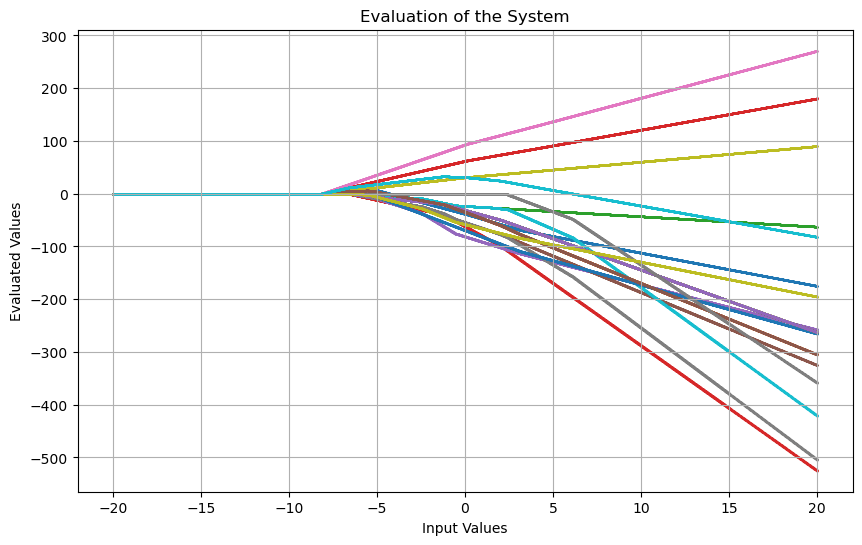

In [10]:
plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f'Equation {i+1}', s=0.1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [11]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size:test_size + train_size]
outofbound_test = expanded_values[test_size + train_size:]

train_outputs, inbound_test_outputs = evaluated_values[:train_size], evaluated_values[train_size:test_size + train_size]
outofbound_test_outputs = evaluated_values[test_size + train_size:]

train_batches = create_batches(train_values, train_outputs, batch_size)
inbound_test_batches = create_batches(inbound_test, inbound_test_outputs, batch_size)
outofbound_test_batches = create_batches(outofbound_test, outofbound_test_outputs, batch_size)

In [12]:
print(train_values.shape, inbound_test.shape, outofbound_test.shape)
print(len(train_batches), len(inbound_test_batches), len(outofbound_test_batches))

(10000, 100) (2000, 100) (2000, 100)
312 62 62


In [13]:
vectors = jnp.concatenate((state.params['params']['custom_activation']['alpha'], state.params['params']['custom_activation']['gamma']), axis=0).T
print(vectors)

[[-0.61345876 -1.0336277  -0.32995364  0.01720903  0.27126575  0.59186888]
 [-1.27909339  1.0656223  -0.67904394  0.78200274  0.04700822  1.06272819]
 [-0.73008145  0.57394528  0.21473152 -0.3552363  -0.89923313  2.13206475]
 [-0.73120367 -0.05726289 -0.18529142  1.8865869   0.37522406  0.97453153]
 [ 0.44328328  0.29787692  0.43489714  1.94128338  0.3132932   1.02484353]]


In [14]:
num_epochs = 201
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_batches:

        state, loss = train_step(state, batch_x, batch_y)
        epoch_loss += loss

    if epoch % 2 == 0:
        inbound_test_loss = evaluate(state, inbound_test_batches)
        outofbound_test_loss = evaluate(state, outofbound_test_batches)
        print(f"Epoch {epoch}, Loss: {epoch_loss/len(train_batches)}, "
              f"Inbound Test Loss: {inbound_test_loss/len(inbound_test_batches)}, Out-of-bound Test Loss: {outofbound_test_loss/len(outofbound_test_batches)}")
        
print("Training complete!")

end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.4f} seconds")

Epoch 0, Loss: 1898.4455393913768, Inbound Test Loss: 5.249434690082384, Out-of-bound Test Loss: 10.999525313125742
Epoch 2, Loss: 284.00708037858374, Inbound Test Loss: 4.104902420241387, Out-of-bound Test Loss: 9.323546195487772
Epoch 4, Loss: 157.15712002149309, Inbound Test Loss: 1.9344495663061427, Out-of-bound Test Loss: 4.578153956834939
Epoch 6, Loss: 68.12856948122746, Inbound Test Loss: 1.006803404485812, Out-of-bound Test Loss: 1.925311599664139
Epoch 8, Loss: 52.50867254315183, Inbound Test Loss: 0.8067179837217491, Out-of-bound Test Loss: 1.6765549511649038
Epoch 10, Loss: 42.64070812604033, Inbound Test Loss: 0.6475111217245226, Out-of-bound Test Loss: 1.7775632247415118
Epoch 12, Loss: 33.58257332946628, Inbound Test Loss: 0.5030288721746694, Out-of-bound Test Loss: 1.7060397285526414
Epoch 14, Loss: 25.388775652792763, Inbound Test Loss: 0.37625158700735706, Out-of-bound Test Loss: 1.448518550007533
Epoch 16, Loss: 18.522900235398442, Inbound Test Loss: 0.27364233889495

In [15]:
vectors = jnp.concatenate((state.params['params']['custom_activation']['alpha'], state.params['params']['custom_activation']['gamma']), axis=0).T
print(vectors)

[[-1.00309729e+00 -1.30038324e+00 -1.13652863e-01 -6.09610402e+00
  -2.40638744e+00 -1.65819011e+00]
 [-1.21091797e+00  9.99603975e-01 -9.36876611e-01  9.25270855e-01
   4.85166866e-01  2.37166612e+00]
 [-7.44453152e-01  5.34590170e-01  5.73526968e-01  2.89664559e-02
  -7.25933650e-03  8.16121853e+00]
 [-1.04786091e+00  4.59671443e-01 -7.68893293e-01  5.55242139e+00
  -1.33038828e-02  2.44693045e+00]
 [ 9.20400403e-01  4.58381354e-01  7.03518249e-01  6.25881034e+00
  -1.75149802e+00  1.01794926e+00]]


[Array(1, dtype=int64), Array(2, dtype=int64), Array(4, dtype=int64), Array(1, dtype=int64), Array(0, dtype=int64)]


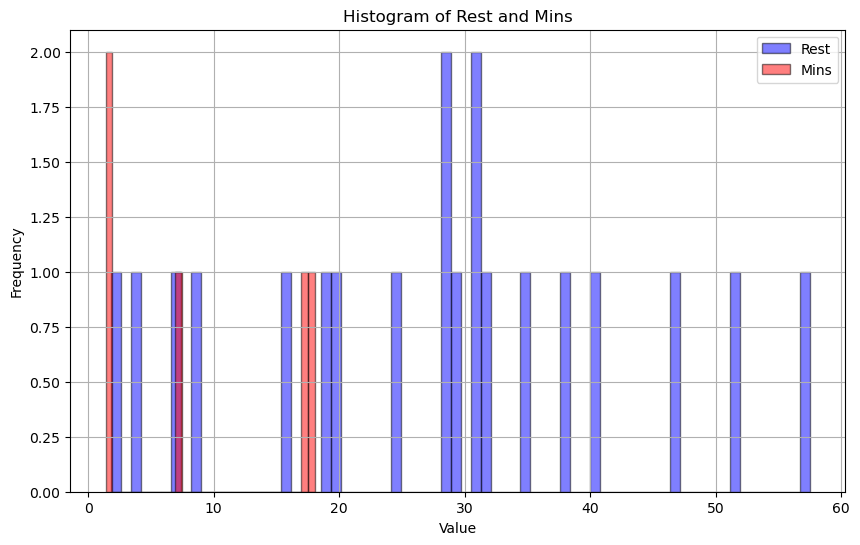

In [16]:
rest = []
mins = []
mins_nls = []

for vec in vectors:
    temp = []
    for nls in vec_nls:
        temp.append(jnp.abs(vec @ nls))
    
    min_value = jnp.min(jnp.array(temp))
    min_index = jnp.argmin(jnp.array(temp))  # Find the index of the minimum value
    
    mins.append(min_value)
    mins_nls.append(min_index)  # Store the `nls` corresponding to the minimum value
    
    # Remove the min value and associated nls
    temp.remove(min_value)
    rest.append(temp)
    
print(mins_nls)
    
plt.figure(figsize=(10, 6))
plt.hist([item for sublist in rest for item in sublist], bins=70, edgecolor='black', alpha=0.5, label='Rest', color='blue')
plt.hist(mins, bins=30, edgecolor='black', alpha=0.5, label='Mins', color='red')
plt.title('Histogram of Rest and Mins')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

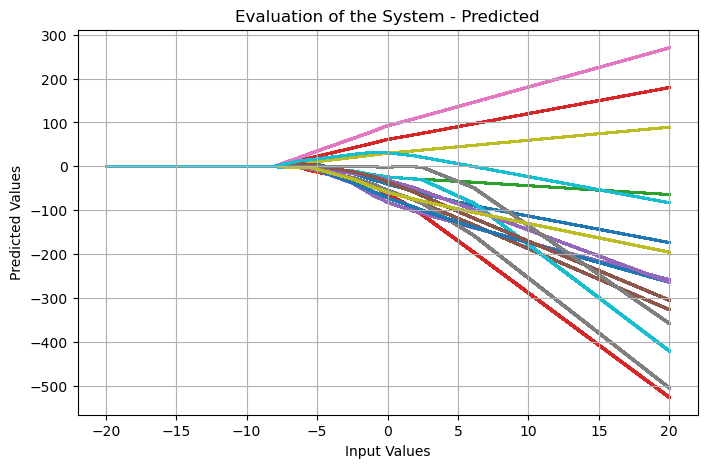

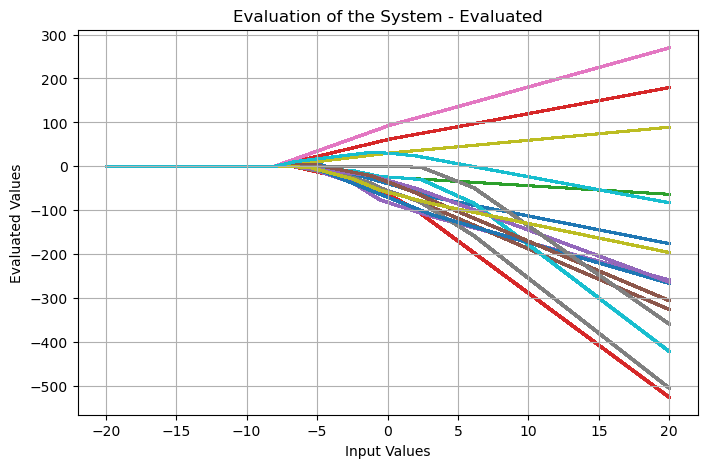

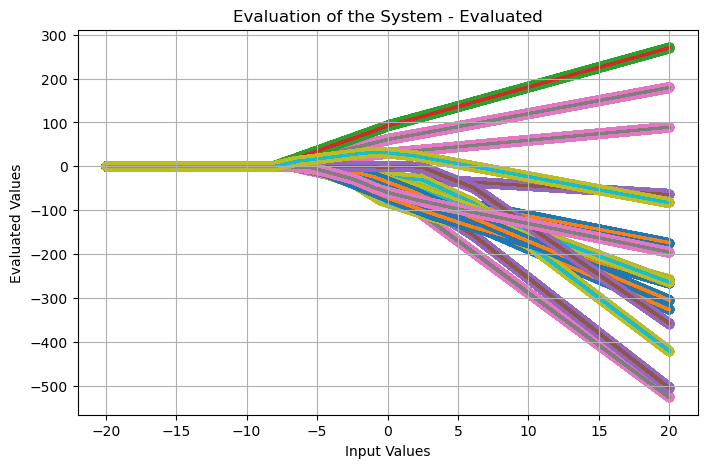

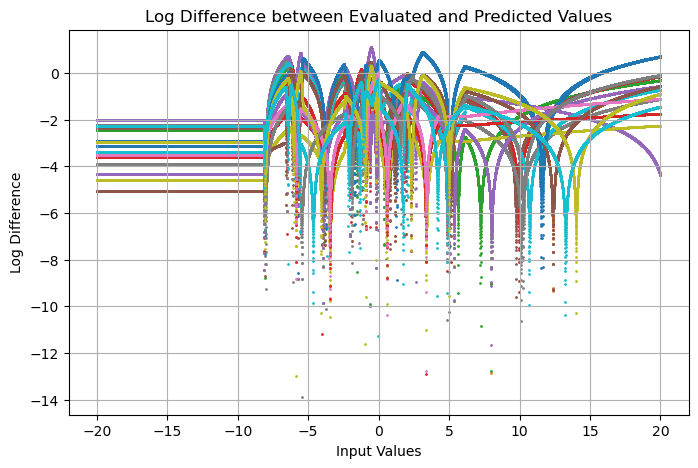

In [17]:
predicted_values = state.apply_fn(state.params, expanded_values)

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], predicted_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of the System - Predicted')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'True {i+1}')
    plt.scatter(values[:, 1], predicted_values[:, i], label=f'Prediction {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], jnp.log(jnp.abs(evaluated_values[:, i] - predicted_values[:, i]) + 1e-7), label=f'Error {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Log Difference')
plt.title('Log Difference between Evaluated and Predicted Values')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.clf()
plt.close()


In [18]:
print(state.params['params']['output_layer']['kernel'])
print(vec_nls)
print(vectors)

[[-0.07760286  0.02006871 -0.0572633  ...  0.48294613 -0.03838447
  -0.09105249]
 [-0.2562226  -0.1385806  -0.07912767 ...  0.07182888 -0.18068534
   0.05944974]
 [ 0.24764591  0.22266923  0.00623175 ...  0.03999652 -0.09480239
   0.6312314 ]
 ...
 [ 0.55193835  0.3462835  -0.19903716 ... -0.09279013 -0.04785037
   0.5815429 ]
 [ 0.51654875  0.33494928  0.20699875 ...  0.03844357  0.55530965
  -0.02328183]
 [-0.03364196 -0.35922906  0.19386336 ... -0.02547079  0.1474997
  -0.11513884]]
[[-4.72350633  4.98900944 -2.22880297  2.46257795  0.55233226  6.43904877]
 [ 1.74802009 -5.10872158 -1.27046248 -3.09998931  5.39552182  5.52356092]
 [-0.90109363  3.80842853  0.06274223 -0.14223513  8.16782402 -4.23631748]
 [-4.90581745 -0.79685476 -5.47846948 -6.10191766 -1.48716614 -2.41646177]
 [-3.66701709 -5.47130689 -2.71841749  6.60409031  1.23307706 -2.02324125]]
[[-1.00309729e+00 -1.30038324e+00 -1.13652863e-01 -6.09610402e+00
  -2.40638744e+00 -1.65819011e+00]
 [-1.21091797e+00  9.99603975e-0

### Uniform

In [19]:
system = Equations(config)

System and state loaded from equations_1b1e7ccc068166d7578a589596465bb9.pkl


In [20]:
# Split random key
key, subkey = random.split(key)

# Generate new training values uniformly in [-bound, bound]
train_values = random.uniform(subkey, shape=(total_size, config['n_vars']), minval=-1 * bound, maxval=bound)

inbound_test = train_values[indices]  # Extract test points
train_values = train_values[mask]  # Remove them from training set

# Generate out-of-bound test values in [-bound-bound_delta, -bound] ∪ [bound, bound+bound_delta]
bound_delta = 5
key, subkey = random.split(key)
range1 = random.uniform(subkey, shape=(test_size//2, config['n_vars']), minval=-1*bound - bound_delta, maxval=-1*bound)
key, subkey = random.split(key)
range2 = random.uniform(subkey, shape=(test_size//2, config['n_vars']), minval=bound, maxval=bound + bound_delta)
outofbound_test = jnp.concatenate((range1, range2), axis=0)

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate training and test values
values = jnp.vstack((train_values, stacked_test))

# Evaluate function on all values
evaluated_values = vmap(my_eval)(values)

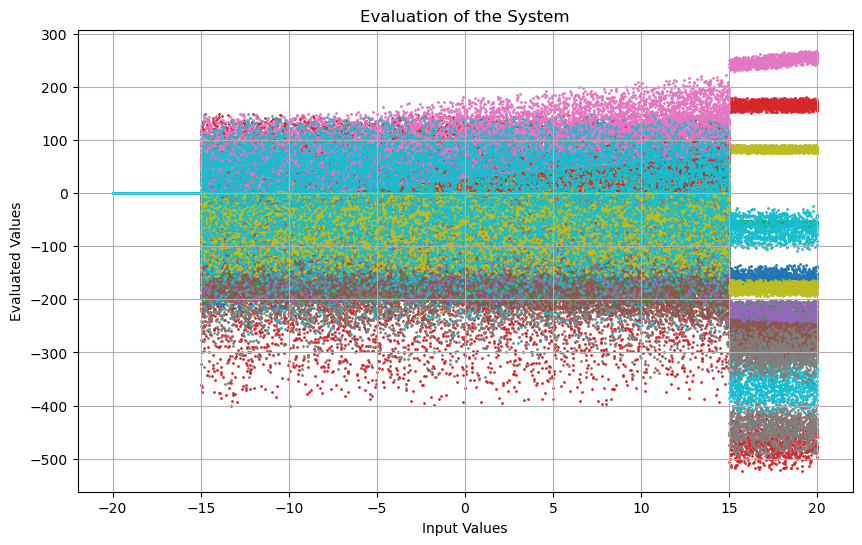

In [21]:
plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [22]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size:test_size + train_size]
outofbound_test = expanded_values[test_size + train_size:]

train_outputs, inbound_test_outputs = evaluated_values[:train_size], evaluated_values[train_size:test_size + train_size]
outofbound_test_outputs = evaluated_values[test_size + train_size:]

train_batches = create_batches(train_values, train_outputs, batch_size)
inbound_test_batches = create_batches(inbound_test, inbound_test_outputs, batch_size)
outofbound_test_batches = create_batches(outofbound_test, outofbound_test_outputs, batch_size)

In [23]:
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [24]:
num_epochs = 201
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_batches:

        state, loss = train_step(state, batch_x, batch_y)
        epoch_loss += loss

    if epoch % 2 == 0:
        inbound_test_loss = evaluate(state, inbound_test_batches)
        outofbound_test_loss = evaluate(state, outofbound_test_batches)
        print(f"Epoch {epoch}, Loss: {epoch_loss/len(train_batches)}, "
              f"Inbound Test Loss: {inbound_test_loss/len(inbound_test_batches)}, Out-of-bound Test Loss: {outofbound_test_loss/len(outofbound_test_batches)}")
        
print("Training complete!")

end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.4f} seconds")

Epoch 0, Loss: 3579.311476346027, Inbound Test Loss: 33.2875658182551, Out-of-bound Test Loss: 68.8172788015622
Epoch 2, Loss: 381.14732687067806, Inbound Test Loss: 3.775681861132107, Out-of-bound Test Loss: 50.31422903818625
Epoch 4, Loss: 173.73218321175355, Inbound Test Loss: 2.7236044055080852, Out-of-bound Test Loss: 41.8531463156174
Epoch 6, Loss: 151.83983156791226, Inbound Test Loss: 2.369823769347986, Out-of-bound Test Loss: 33.11602194243743
Epoch 8, Loss: 128.76942990335016, Inbound Test Loss: 1.9870526502541166, Out-of-bound Test Loss: 23.986984342288512
Epoch 10, Loss: 103.28849803234452, Inbound Test Loss: 1.5641736106027093, Out-of-bound Test Loss: 14.991535374611587
Epoch 12, Loss: 74.56580259181531, Inbound Test Loss: 1.090897539041778, Out-of-bound Test Loss: 7.151388768005143
Epoch 14, Loss: 45.95071254889203, Inbound Test Loss: 0.6448642829658939, Out-of-bound Test Loss: 2.792007748874215
Epoch 16, Loss: 25.81281957680789, Inbound Test Loss: 0.3619144589454524, Out

[Array(4, dtype=int64), Array(2, dtype=int64), Array(1, dtype=int64), Array(0, dtype=int64), Array(3, dtype=int64)]


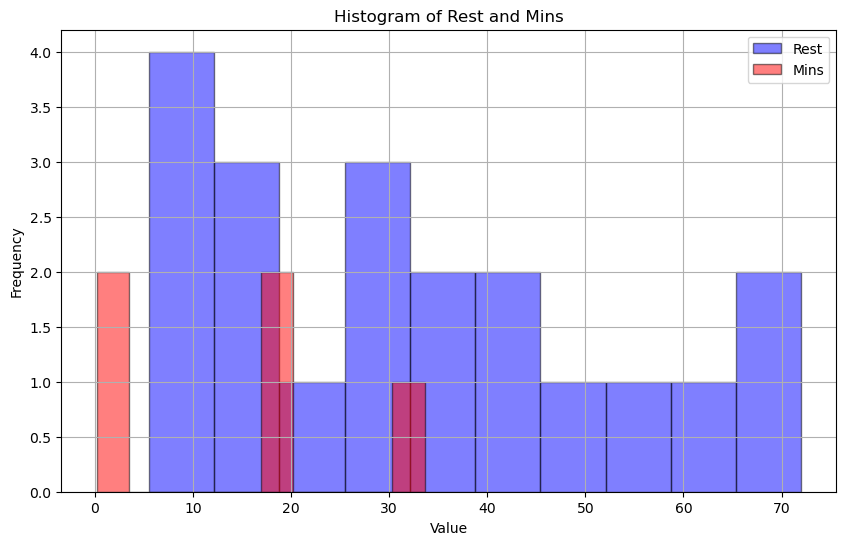

In [25]:
vectors = jnp.concatenate((state.params['params']['custom_activation']['alpha'], state.params['params']['custom_activation']['gamma']), axis=0).T

rest = []
mins = []
mins_nls = []

for vec in vectors:
    temp = []
    for nls in vec_nls:
        temp.append(jnp.abs(vec @ nls))
    
    min_value = jnp.min(jnp.array(temp))
    min_index = jnp.argmin(jnp.array(temp))  # Find the index of the minimum value
    
    mins.append(min_value)
    mins_nls.append(min_index)  # Store the `nls` corresponding to the minimum value
    
    # Remove the min value and associated nls
    temp.remove(min_value)
    rest.append(temp)
    
print(mins_nls)
    
plt.figure(figsize=(10, 6))
plt.hist([item for sublist in rest for item in sublist], bins=10, edgecolor='black', alpha=0.5, label='Rest', color='blue')
plt.hist(mins, bins=10, edgecolor='black', alpha=0.5, label='Mins', color='red')
plt.title('Histogram of Rest and Mins')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
print(vectors)
print(vec_nls)

[[ 1.41928609  1.5341295   1.65855678  5.82673441  5.82909533  4.34601886]
 [-2.30618257 -0.77285306 -0.5529811   8.20065309  6.77697637  4.64473458]
 [ 2.10875025 -0.76694757  2.33920943 -6.09491897  1.44884933 -2.42351149]
 [ 1.04276307  0.80928759  1.69364943 -2.47190097  1.6737872   1.67525756]
 [-0.84977946  2.09330583  2.37848484 -1.52287196 -1.59094949  0.38654298]]
[[-4.72350633  4.98900944 -2.22880297  2.46257795  0.55233226  6.43904877]
 [ 1.74802009 -5.10872158 -1.27046248 -3.09998931  5.39552182  5.52356092]
 [-0.90109363  3.80842853  0.06274223 -0.14223513  8.16782402 -4.23631748]
 [-4.90581745 -0.79685476 -5.47846948 -6.10191766 -1.48716614 -2.41646177]
 [-3.66701709 -5.47130689 -2.71841749  6.60409031  1.23307706 -2.02324125]]


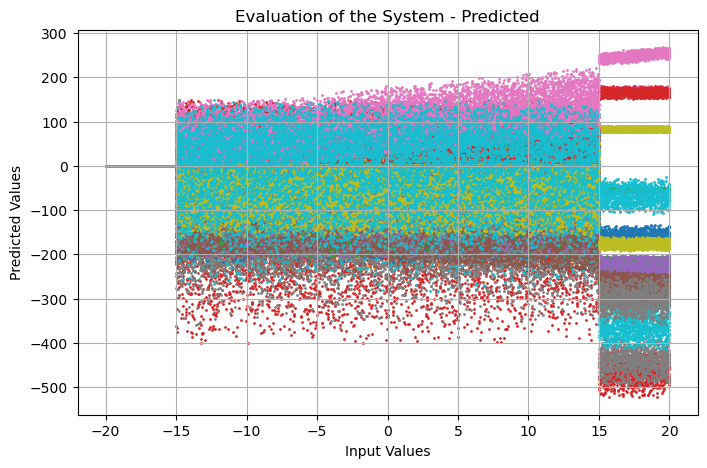

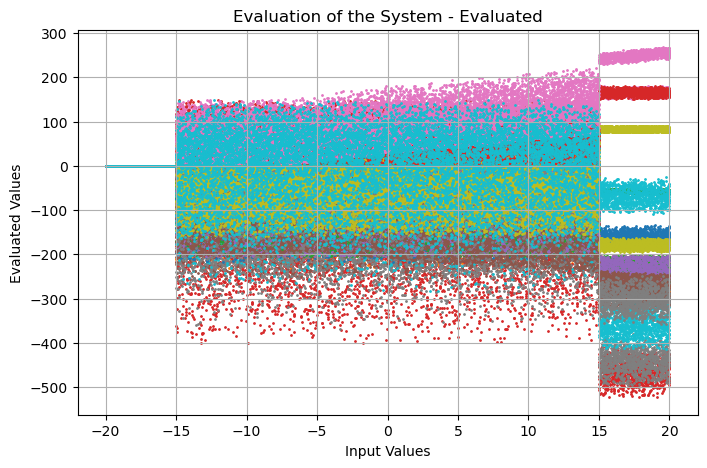

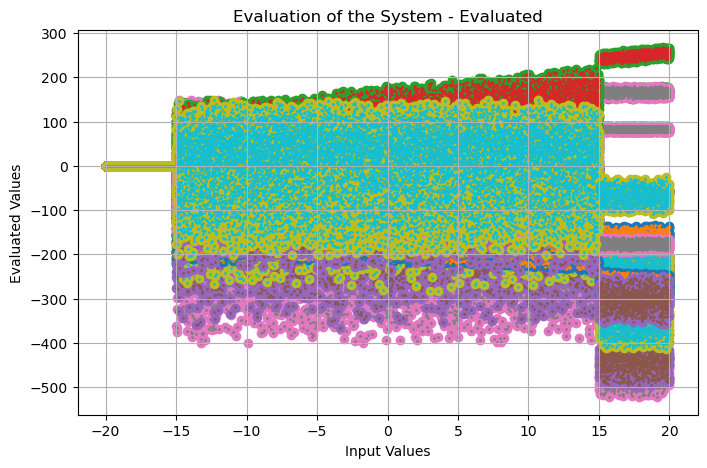

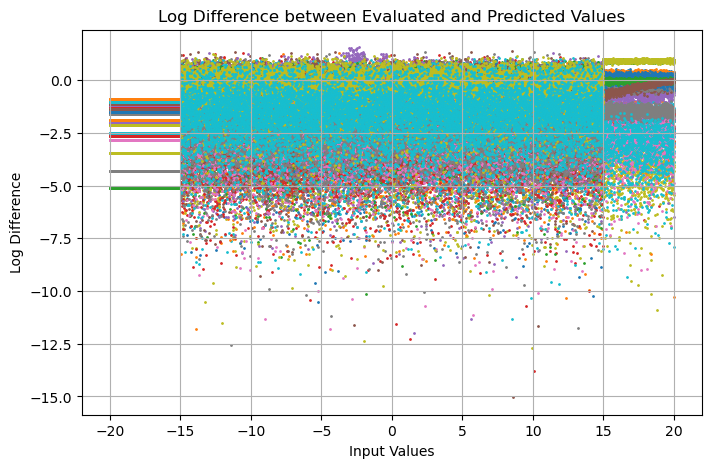

In [27]:
predicted_values = state.apply_fn(state.params, expanded_values)

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], predicted_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of the System - Predicted')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'True {i+1}')
    plt.scatter(values[:, 1], predicted_values[:, i], label=f'Prediction {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], jnp.log(jnp.abs(evaluated_values[:, i] - predicted_values[:, i]) + 1e-7), label=f'Error {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Log Difference')
plt.title('Log Difference between Evaluated and Predicted Values')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.clf()
plt.close()


In [28]:
print(state.params['params']['output_layer']['kernel'])


[[ 2.9404883e-03 -1.4609336e+00  4.9111266e-03 ...  3.3579033e-03
  -2.3584645e-03 -3.1321391e-01]
 [ 1.0359030e-03 -1.2015092e-02  3.8345263e-04 ...  1.3999015e-03
  -2.3486484e-03 -1.4565971e+00]
 [-1.7291220e-03  2.9167306e-01  4.3475283e-03 ...  1.8647905e-04
   3.7388958e-03  2.6759293e-02]
 ...
 [-1.2575574e-03  1.1208639e-03 -3.5473222e-03 ... -1.8950859e-03
  -3.5010362e-03 -5.1035844e-03]
 [-2.9967587e-02 -2.7323425e-02 -2.5256764e-02 ... -1.8999858e-03
  -4.6629485e-02 -6.1887458e-02]
 [ 3.0084148e-02  2.2281110e-02  1.6633634e-02 ...  1.4343355e-03
   3.3134442e-02  5.2831076e-02]]
